Tutorial on Computing HFOs
==========================

In this tutorial, we will walk through how to compute HFOs on a sample dataset that is defined in [1]. 

We will demonstrate usage of the following detectors:

- Line Length detector
- RMS detector
- Morphology detector (used in the paper)

Dataset Preprocessing
---------------------
Note that the data has been converted to BIDS to facilitate easy loading using ``mne-bids`` package. Another thing to note is that the authors in this dataset 
reported HFOs detected using bipolar montage. In addition, they only analyzed HFOs for a subset of the recording channels.

In order to compare results to a monopolar reference, we define an HFO to be "found" if there was an HFO in either of the corresponding bipolar contacts.

References
----------
[1] Fedele T, Burnos S, Boran E, Krayenbühl N, Hilfiker P, Grunwald T, Sarnthein J. Resection of high frequency oscillations predicts seizure outcome in the individual patient.
Scientific Reports. 2017;7(1):13836.
https://www.nature.com/articles/s41598-017-13064-1
doi:10.1038/s41598-017-13064-1

In [1]:
# first let's load in all our packages
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import re
import pandas as pd

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

from mne_bids import (read_raw_bids, BIDSPath, 
                      get_entity_vals, get_datatypes, 
                      make_report)
from mne_bids.stats import count_events

import mne
from mne import make_ad_hoc_cov
from mne.datasets import sample

basepath = os.path.join(os.getcwd(), "../..")
sys.path.append(basepath)
from mne_hfo import LineLengthDetector, RMSDetector
from mne_hfo.simulate import simulate_hfo, simulate_line_noise
from mne_hfo.score import _compute_score_data, accuracy
from mne_hfo.sklearn import make_Xy_sklearn, DisabledCV

# 1 Simulated Data

## 1.1 Simulate the HFO data

We will first create a simulated version of an HFO, which we can run through the detection algorithms to show a simple use case. We will create two HFOs, one in the ripple frequency (80-250 Hz) and one in the fast ripple frequency (250-500 Hz). We will then plot the simulated data

### 1.1.1 Create and plot the simulated HFOs

In [2]:
# Simulate ripple and fast ripple HFOs
ripple_data, ripple_time = simulate_hfo(fs=2000, freq=120)
#ripple_data = ripple_data.reshape(1, len(ripple_data))
fast_ripple_data, fast_ripple_time = simulate_hfo(fs=2000, freq=400)

Text(0.5, 1.0, 'Simulated Fast Ripple')

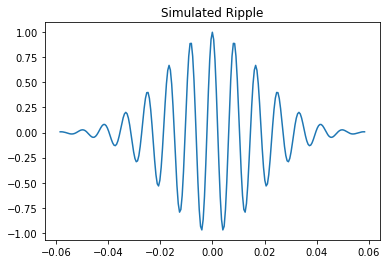

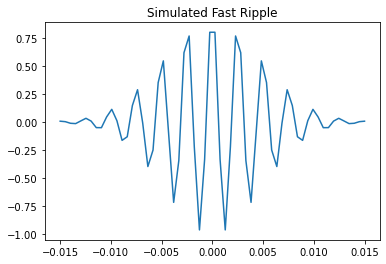

In [3]:
fig = plt.figure()
ax = plt.axes()
ax.plot(ripple_time, ripple_data)
plt.title("Simulated Ripple")

fig = plt.figure()
ax = plt.axes()
ax.plot(fast_ripple_time, fast_ripple_data)
plt.title("Simulated Fast Ripple")

### 1.1.2 Add other "simulated" EEG data
These detectors work by finding patterns that deviate from the normal, so we need some "normal" EEG attached to the simulated HFO signal for the detectors to work. We can do this by grabbing a small segment of real EEG data from mne's samples.

In [4]:
%%capture
# Load in template data
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
fwd_fname = data_path + '/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif'

# Load real data as the template
raw = mne.io.read_raw_fif(raw_fname)
raw.set_eeg_reference(projection=True)
raw = raw.pick_channels(['EEG 001'])
sfreq = int(np.round(raw.info['sfreq']))
# Get two seconds of data to add before and after the HFO
raw_data_front = raw.get_data(start=0, stop=2*sfreq)[0]
raw_data_back = raw.get_data(start=2*sfreq, stop=4*sfreq)[0]
times = np.linspace(0, 2, 2*sfreq)

Text(0.5, 1.0, 'Raw Data Sample (Back)')

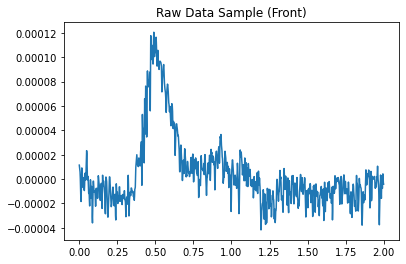

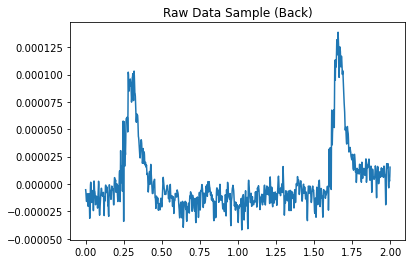

In [5]:
# Visualize the raw data
fig = plt.figure()
ax = plt.axes()
ax.plot(times, raw_data_front)
plt.title("Raw Data Sample (Front)")

fig = plt.figure()
ax = plt.axes()
ax.plot(times, raw_data_back)
plt.title("Raw Data Sample (Back)")
#plt.plot(times, raw_data_back)

### 1.1.3 Combine the simulated data with sample data
Append the data to the front and back of the simulated HFOs

In [6]:
def change_scale(val, aim_min, aim_max, cur_min, cur_max):
    return (val - cur_min) * (aim_max - aim_min) / (cur_max - cur_min) + aim_min

In [7]:
# Normalize ripple data scale to that of the sample data
sig_min = np.min([np.min(raw_data_front), np.min(raw_data_back)])
sig_max = np.max([np.max(raw_data_front), np.max(raw_data_back)])
ripple_min = np.min(ripple_data)
ripple_max = np.max(ripple_data)
fast_ripple_min = np.min(fast_ripple_data)
fast_ripple_max = np.max(fast_ripple_data)

ripple_data = [change_scale(r, sig_min, sig_max, ripple_min, ripple_max) for r in ripple_data]
fast_ripple_data = [change_scale(r, sig_min, sig_max, fast_ripple_min, fast_ripple_max) for r in fast_ripple_data]

In [8]:
# Combine the datasets and create new time vectors
ripple_data_total = np.concatenate((raw_data_front, ripple_data, raw_data_back))
t_total = len(raw_data_front) + len(ripple_data) + len(raw_data_back)
ripple_times_total = np.linspace(0, t_total/sfreq, t_total)

fast_ripple_data_total = np.concatenate((raw_data_front, fast_ripple_data, raw_data_back))
fast_t_total = len(raw_data_front) + len(fast_ripple_data) + len(raw_data_back)
fast_ripple_times_total = np.linspace(0, fast_t_total/sfreq, fast_t_total)


Text(0.5, 1.0, 'Simulated data with Fast Ripple')

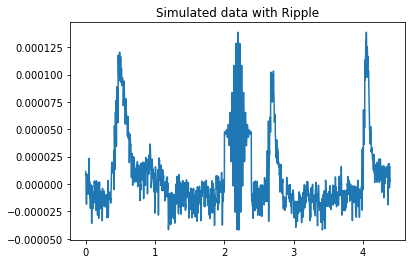

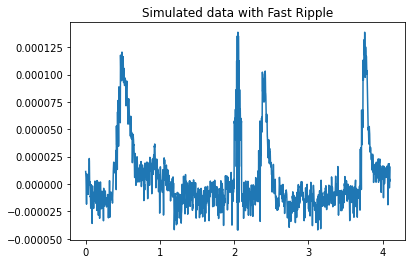

In [9]:
# Visualize
fig = plt.figure()
ax = plt.axes()
ax.plot(ripple_times_total, ripple_data_total)
plt.title("Simulated data with Ripple")

fig = plt.figure()
ax = plt.axes()
ax.plot(fast_ripple_times_total, fast_ripple_data_total)
plt.title("Simulated data with Fast Ripple")

In [10]:
# Reshape the data to fit detector requirements
ripple_data_total = ripple_data_total.reshape(1, len(ripple_data_total))
fast_ripple_data_total = fast_ripple_data_total.reshape(1, len(fast_ripple_data_total))

## 1.2 Detect the HFOs

We have two detectors that can detect the presense of an HFO, a LineLengthDetector and an RMSDetector. We will plug the simulated data into each detector to demonstrate the presence of HFOs.

### 1.2.1 Line Length Detector

In [11]:
# Set Key Word Arguments for the Line Length Detector and generate the class object
kwargs = {
    'filter_band': (80, 250), # (l_freq, h_freq)
    'threshold': 3, # Number of st. deviations
    'win_size': 100, # Sliding window size in samples
    'overlap': 0.25, # Fraction of window overlap [0, 1]
    'sfreq': 2000,  # Sampling frequency of data
}
ll_detector = LineLengthDetector(**kwargs)

In [12]:
%%capture
# Detect HFOs in the raw data using the LineLengthDetector method.
# Return the class object with HFOs added
ll_detector = ll_detector.fit(ripple_data_total)

# Dictionary where keys are channel index and values are a list of tuples in the form of (start_samp, end_samp)
chs_hfo_dict = ll_detector.chs_hfos_ 
# nCh x nWin ndarray where each value is the line-length of the data window per channel
hfo_event_array = ll_detector.hfo_event_arr_
# Pandas dataframe containing onset, duration, sample trial, and trial type per HFO
hfo_df = ll_detector.df_

### 1.2.2 Check Results
We should see a single HFO starting around 2 seconds and ending a small amount after

In [13]:
detected_hfos = chs_hfo_dict.get("0")
for hfo in detected_hfos:
    start_samp = hfo[0]
    end_samp = hfo[1]
    start_time = start_samp / sfreq
    end_time = end_samp / sfreq
    print(f"Detected a ripple HFO starting at {start_time}s and ending at {end_time}s")

Detected a ripple HFO starting at 2.0798668885191347s and ending at 2.4126455906821964s


### 1.2.3 Repeat for RMS Detector
We should get almost the exact same result

In [14]:
%%capture
# Set Key Word Arguments for the Line Length Detector and generate the class object
kwargs = {
    'filter_band': (80, 250),
    'threshold': 3,
    'win_size': 100,
    'overlap': 0.25,
    'sfreq': 2000,
}
rms_detector = RMSDetector(**kwargs)
rms_detector = rms_detector.fit(ripple_data_total)
chs_hfo_dict = rms_detector.chs_hfos_ 

In [15]:
detected_hfos = chs_hfo_dict.get("0")
for hfo in detected_hfos:
    start_samp = hfo[0]
    end_samp = hfo[1]
    start_time = start_samp / sfreq
    end_time = end_samp / sfreq
    print(f"Detected a ripple HFO starting at {start_time}s and ending at {end_time}s")

Detected a ripple HFO starting at 2.0798668885191347s and ending at 2.4126455906821964s


### 1.2.4 Repeat for the fast ripple dataset
We should expect similar results

In [16]:
%%capture
# Line length Detector
kwargs = {
    'filter_band': (250, 500),
    'threshold': 3,
    'win_size': 100,
    'overlap': 0.25,
    'sfreq': 2000,
}
ll_detector = LineLengthDetector(**kwargs)
ll_detector = ll_detector.fit(fast_ripple_data_total)
ll_chs_hfo_dict = ll_detector.chs_hfos_ 

# RMS detector
rms_detector = RMSDetector(**kwargs)
rms_detector = rms_detector.fit(fast_ripple_data_total)
rms_chs_hfo_dict = rms_detector.chs_hfos_ 

In [17]:
detected_hfos = ll_chs_hfo_dict.get("0")
for hfo in detected_hfos:
    start_samp = hfo[0]
    end_samp = hfo[1]
    start_time = start_samp / sfreq
    end_time = end_samp / sfreq
    print(f"Detected a fast ripple HFO starting at {start_time}s and ending at {end_time}s using the LineLength Detector")

detected_hfos = rms_chs_hfo_dict.get("0")
for hfo in detected_hfos:
    start_samp = hfo[0]
    end_samp = hfo[1]
    start_time = start_samp / sfreq
    end_time = end_samp / sfreq
    print(f"Detected a fast ripple HFO starting at {start_time}s and ending at {end_time}s using the RMS detector")

Detected a fast ripple HFO starting at 1.9966722129783694s and ending at 2.2462562396006653s using the LineLength Detector
Detected a fast ripple HFO starting at 1.9966722129783694s and ending at 2.2462562396006653s using the RMS detector


### 1.2.5 More complex Example
Now let's combine the two datasets to show how the detectors differentiate the ripple types.

The detectors set to the ripple frequency band (80-250Hz) should only detect a single HFO (ripple) around the 2 second mark. The detectors set to the fast ripple frequency band (250-500Hz) should only detect a single HFO (fast ripple) around the 6 second mark (will vary based on the length of the ripple wave added).

Text(0.5, 1.0, 'Simulated data with Ripple and Fast Ripple')

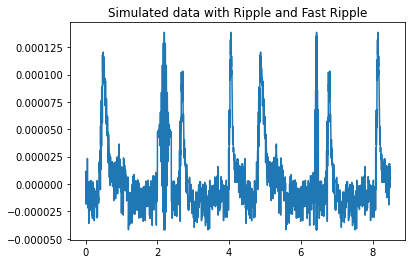

In [18]:
# Combine
hfo_data_total = np.concatenate((ripple_data_total, fast_ripple_data_total), axis=1)
hfo_times_total = np.linspace(0, hfo_data_total.shape[1]/sfreq, hfo_data_total.shape[1])

# Reshape just for plotting
hfo_data_total_plot = hfo_data_total.reshape(hfo_data_total.shape[1], 1)

# Plot
fig = plt.figure()
ax = plt.axes()
ax.plot(hfo_times_total, hfo_data_total_plot)
plt.title("Simulated data with Ripple and Fast Ripple")

In [19]:
%%capture
# First look for ripples
# Line length Detector
kwargs = {
    'filter_band': (80, 250),
    'threshold': 3,
    'win_size': 100,
    'overlap': 0.25,
    'sfreq': 2000,
}
ll_detector = LineLengthDetector(**kwargs)
ll_detector = ll_detector.fit(hfo_data_total)
ll_chs_hfo_dict = ll_detector.chs_hfos_ 

# RMS detector
rms_detector = RMSDetector(**kwargs)
rms_detector = rms_detector.fit(hfo_data_total)
rms_chs_hfo_dict = rms_detector.chs_hfos_ 

# Then look for fast ripples
# Line length Detector
kwargs = {
    'filter_band': (250, 500),
    'threshold': 3,
    'win_size': 100,
    'overlap': 0.25,
    'sfreq': 2000,
}
ll_detector = LineLengthDetector(**kwargs)
ll_detector = ll_detector.fit(hfo_data_total)
ll_fr_chs_hfo_dict = ll_detector.chs_hfos_ 

# RMS detector
rms_detector = RMSDetector(**kwargs)
rms_detector = rms_detector.fit(hfo_data_total)
rms_fr_chs_hfo_dict = rms_detector.chs_hfos_ 


In [20]:
detected_hfos = ll_chs_hfo_dict.get("0")
for hfo in detected_hfos:
    start_samp = hfo[0]
    end_samp = hfo[1]
    start_time = start_samp / sfreq
    end_time = end_samp / sfreq
    print(f"Detected a ripple HFO starting at {start_time}s and ending at {end_time}s using the LineLength Detector")
    


detected_hfos = rms_chs_hfo_dict.get("0")
for hfo in detected_hfos:
    start_samp = hfo[0]
    end_samp = hfo[1]
    start_time = start_samp / sfreq
    end_time = end_samp / sfreq
    print(f"Detected a ripple HFO starting at {start_time}s and ending at {end_time}s using the RMS detector")
    
detected_hfos = ll_fr_chs_hfo_dict.get("0")
for hfo in detected_hfos:
    start_samp = hfo[0]
    end_samp = hfo[1]
    start_time = start_samp / sfreq
    end_time = end_samp / sfreq
    print(f"Detected a fast ripple HFO starting at {start_time}s and ending at {end_time}s using the LineLength Detector")
    

detected_hfos = rms_fr_chs_hfo_dict.get("0")
for hfo in detected_hfos:
    start_samp = hfo[0]
    end_samp = hfo[1]
    start_time = start_samp / sfreq
    end_time = end_samp / sfreq
    print(f"Detected a fast ripple HFO starting at {start_time}s and ending at {end_time}s using the RMS detector")

Detected a ripple HFO starting at 2.0798668885191347s and ending at 2.4126455906821964s using the LineLength Detector
Detected a ripple HFO starting at 2.0798668885191347s and ending at 2.4126455906821964s using the RMS detector
Detected a fast ripple HFO starting at 6.364392678868552s and ending at 6.613976705490849s using the LineLength Detector
Detected a fast ripple HFO starting at 6.364392678868552s and ending at 6.655574043261232s using the RMS detector


# 2 Working with Real Data
We are now going to work with the dataset from Fedele et al. linked above

## 2.1 Load in Real Data

### 2.1.1 Define dataset paths and load the data

The data is assumed to be in BIDS format. We have converted the dataset into BIDS, 
which you can load using [mne-bids](https://github.com/mne-tools/mne-bids).

In [21]:
# this may change depending on where you store the data
root = '/Users/patrick/Dropbox/fedele_hfo_data'

In [22]:
# print a boiler plate summary report using mne-bids
report = make_report(root, verbose=False)
print(report)

Summarizing participants.tsv /Users/patrick/Dropbox/fedele_hfo_data/participants.tsv...
The iEEG Interictal Asleep HFO Dataset dataset was created with BIDS version
1.4.0 by Fedele T, Burnos S, Boran E, Krayenbühl N, Hilfiker P, Grunwald T, and
Sarnthein J.. This report was generated with MNE-BIDS
(https://doi.org/10.21105/joss.01896). The dataset consists of 20 participants
(comprised of 13 men and 6 women; handedness were all unknown; ages ranged from
17.0 to 52.0 (mean = 32.47, std = 11.43; 1 with unknown age))and 1 recording
sessions: interictalsleep. Data was recorded using a iEEG system (Neuralynx
manufacturer) sampled at 2000.0 Hz with line noise at 50.0 Hz using Sampling
with parameters 2000 Downsampled (Hz). There were 385 scans in total. Recording
durations ranged from 204.0 to 720.0 seconds (mean = 302.44, std = 37.85), for a
total of 116438.81 seconds of data recorded over all scans. For each dataset,
there were on average 51.88 (std = 15.55) recording channels per scan, ou

In [23]:
# there are iEEG datatypes throughout the dataset
datatypes = get_datatypes(root)

# get all the subjects, sessions
subjects = get_entity_vals(root, 'subject')
sessions = get_entity_vals(root, 'session')

In [24]:
# construct BIDSPath for dataset we will demo
subjectID = subjects[0]
sessionID = sessions[0]
bids_path = BIDSPath(subject=subjectID, session=sessionID,
                     datatype='ieeg', 
                     suffix='ieeg',
                     extension='.vhdr', root=root)

# get all matching datasets
fpaths = bids_path.match()

print(f'Found {len(fpaths)} matching filepaths for this subject and session.')

Found 28 matching filepaths for this subject and session.


In [25]:
# analyze the first run
dataset_path = fpaths[0]
print(dataset_path)

# count the different HFO types (fr, ripple, frandr) that were detected using 
# the published Morphology detector
counts_df = count_events(dataset_path)
display(counts_df)

/Users/patrick/Dropbox/fedele_hfo_data/sub-01/ses-interictalsleep/ieeg/sub-01_ses-interictalsleep_run-01_ieeg.vhdr


NaN                                        \
trial_type                  fr_AHR1-2 fr_AHR2-3 fr_AHR3-4 fr_AL1-2 fr_AL2-3   
subject session         run                                                   
01      interictalsleep 01         15        23        12       15       19   

                                                                          ...  \
trial_type                  fr_AL3-4 fr_AR1-2 fr_AR2-3 fr_AR3-4 fr_HL1-2  ...   
subject session         run                                               ...   
01      interictalsleep 01        20       25       28       11        9  ...   

                                                                       \
trial_type                  ripple_IAR2-3 ripple_IAR3-4 ripple_IAR4-5   
subject session         run                                             
01      interictalsleep 01            351           223           179   

                                                                       \
trial_type                  ripple_IAR5-6 ripple_IPR1-2 ripple_IPR2-3   
subject session         run                                             
01      interictalsleep 01            238            12            32   

                                                                       \
trial_type                  ripple_IPR3-4 ripple_PHR1-2 ripple_PHR2-3   
subject session         run                                             
01      interictalsleep 01            128           121           111   

                                           
trial_type                  ripple_PHR3-4  
subject session         run                
01      interictalsleep 01             64  

[1 rows x 60 columns]

In [26]:
%%capture
# load dataset into mne Raw object
extra_params = dict(preload=True)
raw = read_raw_bids(dataset_path, extra_params)

In [27]:
# Optional - Change backend to interactive for below plot
# Allows you to scroll dataset, highlight (or grey out) certain channels, zoom in/out, etc.
%matplotlib notebook

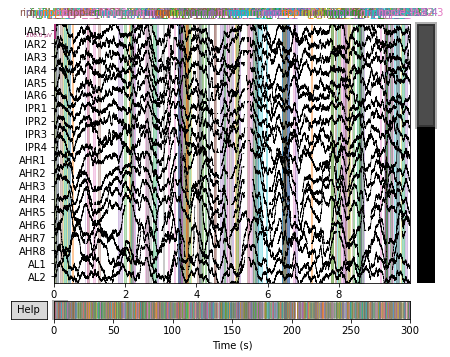

plotting channels with HFO events detected in the original publication in color.


<ipython-input-29-85590d0d121e>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  raw_plot.show()


In [29]:
# Plot the raw data with vertical colorbars to denote where HFOs were detected
raw_plot = raw.plot()
raw_plot.show()
print('plotting channels with HFO events detected in '
      'the original publication in color.')

In [28]:
# Optional - Change back to regular plots
%matplotlib inline

### 2.1.2 Convert to bipolar referencing scheme
The Fedele paper seems to use bipolar referenced channels, so we do our best to compare here


In [30]:
def convert_to_bipolar(raw, drop_originals=True):
    original_ch_names = raw.ch_names
    ch_names_sorted = sorted(original_ch_names)
    ch_pairs = [] 
    for first, second in zip(ch_names_sorted, ch_names_sorted[1:]):
        firstName = re.sub(r'[0-9]+', '', first)
        secondName = re.sub(r'[0-9]+', '', second)
        if firstName == secondName:
            ch_pairs.append((first,second))
    for ch_pair in ch_pairs:
        raw = mne.set_bipolar_reference(raw, ch_pair[0], ch_pair[1], drop_refs=False)
    if drop_originals:
        raw = raw.drop_channels(original_ch_names)
    return raw


In [31]:
%%capture
raw = convert_to_bipolar(raw)

### 2.1.3 Load Annotated HFOs

In [32]:
# All annotated HFO events for this file
annotations = raw.annotations

In [33]:
# The fedele bipolar names use the scheme CH#-#, but mne-bipolar uses the scheme CH#-CH#. Reconstructing 
# the fedele names to match mne names 
def reconstruct_channel_name_to_mne(ch_name):
    ch_split = ch_name.split("-")
    cont_name = re.sub(r'[0-9]+', '', ch_split[0])
    ch_name_mne = f"{ch_split[0]}-{cont_name}{ch_split[1]}"
    return ch_name_mne

# You can also go the other way around. If we convert the mne names to the fedele names, you can use
# the mne.io.Raw.rename_channels function
def reconstruct_mne_channel_name_to_fedele(ch_name):
    ch_split = ch_name.split("-")
    cont_name = re.sub(r'[0-9]+', '', ch_split[0])
    ch_name_fedele = f"{ch_split[0]-{ch_split[1].replace(cont_name, '')}}"
    return ch_name_fedele

In [34]:
# Convert to convenient data structure (pandas DF)
column_names = ["onset", "duration", "sample", "label", "channels"]

sfreq = raw.info["sfreq"]
rows = []
for annot in annotations:
    onset = float(annot.get("onset"))
    duration = float(annot.get("duration"))
    sample = onset * sfreq
    trial_type = annot.get("description").split("_")[0]
    ch_name = annot.get("description").split("_")[1]
    ch_name = reconstruct_channel_name_to_mne(ch_name)
    annot_row = [onset, duration, sample, trial_type, ch_name]
    rows.append(annot_row)

gs_df = pd.concat([pd.DataFrame([row], columns=column_names) for row in rows],
          ignore_index=True)

In [35]:
# for now, lets just look at ripple events:
gs_df_ripple = gs_df[gs_df['label'].str.contains("ripple")]
gs_df_ripple = gs_df_ripple.dropna()
gs_df_ripple.reset_index(drop=True, inplace=True)

## 2.2 Detect HFOs


### 2.2.1 Line Length Detector

In [36]:
# Set Key Word Arguments for the Line Length Detector and generate the class object
kwargs = {
    'filter_band': (80, 250), # (l_freq, h_freq)
    'threshold': 3, # Number of st. deviations
    'win_size': 100, # Sliding window size in samples
    'overlap': 0.25, # Fraction of window overlap [0, 1]
    'hfo_name': "ripple"
}
ll_detector = LineLengthDetector(**kwargs)

In [37]:
%%capture
# Detect HFOs in the raw data using the LineLengthDetector method.
# Return the class object with HFOs added
ll_detector = ll_detector.fit(raw)

# Dictionary where keys are channel index and values are a list of tuples in the form of (start_samp, end_samp)
ll_chs_hfo_dict = ll_detector.chs_hfos_ 
# nCh x nWin ndarray where each value is the line-length of the data window per channel
ll_hfo_event_array = ll_detector.hfo_event_arr_
# Pandas dataframe containing onset, duration, sample trial, and trial type per HFO
ll_hfo_df = ll_detector.df_

### 2.2.2 RMS Detector


In [38]:
# Set Key Word Arguments for the RMS Detector and generate the class object
kwargs = {
    'filter_band': (80, 250),
    'threshold': 3,
    'win_size': 100,
    'overlap': 0.25,
    'hfo_name': 'ripple',
}
rms_detector = RMSDetector(**kwargs)

In [39]:
%%capture
# Detect HFOs in the raw data using the RMSDetector method.
rms_detector = rms_detector.fit(raw)

rms_chs_hfo_dict = rms_detector.chs_hfos_ 
rms_hfo_event_array = rms_detector.hfo_event_arr_
rms_hfo_df = rms_detector.df_

## 2.3 Compare Results

### 2.3.1 Find matches
Now that our dataframes are in the same format, we can compare them. We will simply look at the matches for ripples, since that is what the the detectors looked for. We will compute, for each detection, the accuracy, precision, true positive rate, false negative rate, and false discovery rate. 

In [40]:
def scores_to_df(score_dict):
    df = pd.DataFrame(columns=['detector', 'accuracy', 'true positive rate', 'precision', 'false negative rate', 'false discovery rate'])
    for detector_name, scores in score_dict.items():
        to_append = [detector_name]
        [to_append.append(str(score)) for score in scores]
        append_series = pd.Series(to_append, index = df.columns)
        df = df.append(append_series, ignore_index=True)
    return df

In [41]:
# Note: Since we are computing every score at once, we take a shortcut by calling the internal
# function _compute_score_data, which gives the number of true positives, false positives, 
# and false negatives. There are no true negatives in this dataset

# Gold standard vs LineLengthDetector
scores_dict = {}
tp, fp, fn = _compute_score_data(gs_df, ll_hfo_df, method="match-total")
acc_ll = tp / (tp + fp + fn) 
tpr_ll = tp / (tp + fn)
prec_ll = tp / (tp + fp)
fnr_ll = fn / (fn + tp)
fdr_ll = fp / (fp + tp)
scores_dict["LineLengthDetector"] = [acc_ll, tpr_ll, prec_ll, fnr_ll, fdr_ll]

# Gold standard vs RMSDetector
tp, fp, fn = _compute_score_data(gs_df, rms_hfo_df, method="match-total")
acc_rms = tp / (tp + fp + fn) 
tpr_rms = tp / (tp + fn)
prec_rms = tp / (tp + fp)
fnr_rms = fn / (fn + tp)
fdr_rms = fp / (fp + tp)
scores_dict["RMSDetector"] = [acc_rms, tpr_rms, prec_rms, fnr_rms, fdr_rms]

scores_df = scores_to_df(scores_dict)
scores_df


,detector,accuracy,true positive rate,precision,false negative rate,false discovery rate
0,LineLengthDetector,0.2599502487562189,0.4336099585062241,0.3935969868173258,0.5663900414937759,0.6064030131826742
1,RMSDetector,0.26991030171242186,0.45749827228749135,0.39696182290625626,0.5425017277125086,0.6030381770937437


# 3 Optimizing the Detectors
The above detectors did decently well, but the hyperparameters were randomly set. Let's walk through the procedure
for optimizing the hyperparameters based using GridSearch Cross Validation on the LineLengthDetector

## 3.1 Set up the data
SKlearn requires some changes to the input data and true labels in order for the procedure to function. We
provide some helper functions to assist in the data conversion

In [42]:
raw_df, y = make_Xy_sklearn(raw, gs_df_ripple)

## 3.2 Set up the GridSearchCV function
We will be testing three possible threshold values and three possible win_size values, for a total of 9 tests.
Accuracy will be the only test used for speed purposes, but multiple scoring functions can be passed in at once.

In [43]:
scorer = accuracy
parameters = {'threshold': [1, 2, 3], 'win_size': [50, 100, 250]}
kwargs = {
    'filter_band': (80, 250),
    'overlap': 0.25,
    'hfo_name': 'ripple',
}
detector = LineLengthDetector(**kwargs)
scorer = make_scorer(scorer)
cv = DisabledCV()
gs = GridSearchCV(detector, param_grid=parameters, scoring=scorer, cv=cv,
                  verbose=True)

## 3.3 Perform the Search and Print Output

In [44]:
%%time
%%capture
gs.fit(raw_df, y, groups=None)

CPU times: user 2min 46s, sys: 10.8 s, total: 2min 56s
Wall time: 6min 10s


In [45]:
# Nicely display the output
pd.concat([pd.DataFrame(gs.cv_results_["params"]),pd.DataFrame(gs.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)

,threshold,win_size,Accuracy
0,1,50,0.000000
1,1,100,0.000000
2,1,250,0.136080
3,2,50,0.000000
4,2,100,0.152935
5,2,250,0.225537
6,3,50,0.205174
7,3,100,0.238337
8,3,250,0.232798
